In [1]:
%cd ..

/Users/raiota/git/github.com/raiota/Sound-Simulation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

from tools import *

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["font.size"] = 15

# 1. Sound Field Simulation

## 1.A. 単一音源からの放射音場
点音源による放射音場を計算します．

### 1.A.1. 各種パラメータの設定
離散化ステップ$0.02 \mathrm{[m]}$，$x \in [0, 4] \mathrm{[m]}$，$y \in [-2, 2] \mathrm{[m]}$，$z=0$の平面について計算します．
対象とする周波数は$1000 \mathrm{[Hz]}$とします．音源位置は$(1.0, 0, 0)$とします．

In [6]:
STEP = 0.02
X = np.arange(0, 4+STEP, STEP)
Y = np.arange(-2, 2+STEP, STEP)
Z = np.array([0])
SOURCE = np.array([1.0, 0, 0,])

FREQS = np.array([1000])

### 1.A.2. 受音点のオブジェクト生成
```receiver```モジュール内の```ReceiverParams```クラスを用いて，受音点の一覧を格納したオブジェクトを生成します．<br>
このオブジェクトは```pandas.DataFrame```を継承し，受音点の情報を属性として保持します．<br>
引数```is_meshgrid```を```True```に選択することで，入力されたx,y,zについてメッシュグリッドを生成します．<br>
（このメッシュグリッドの生成には```numpy.meshgrid(x, y, z, indexing='xy)```が用いられます．）<br>
引数```description```では，この受音点の情報を判別するための任意の文字列を選択できます．
```ReceiverParams```のメソッドと属性は以下の通りです．

| ```receiver.ReceiverParams.``` | type | 備考 |
|---|---|---|
| ```__init__(x, y, z, is_meshgrid=True, description='control_points`)``` |   |   |
| ```DESCRIPTION``` | Attribute | 受音点の情報 |
| ```get_coord_data()``` | method | 入力した生の座標情報を返す |

In [5]:
FIELDS = ReceiverParams(x=X, y=Y, z=Z, is_meshgrid=True, description='mesh points')

### 1.A.3. 音源のオブジェクト生成
```source```モジュール内の```SourceParams```クラスを用いて，音源の一覧を格納したオブジェクトを生成します．<br>
引数```shape```は音源の形状を表し，```source.SourceCategory```クラスを用いて指定します．<br>
選択可能な音源形状は以下の表の通りです．各音源に共通の```x, y, z```は，デカルト座標系における音源位置です．

| ```source.SourceCategory.``` | 形状 | パラメータ | 備考
|---|---|---|---|
| ```POINT``` | 点音源 | ```x, y, z``` | 無指向性 |
| ```LINE``` | 線音源 | ```x, y, z, length, elevation, azimuth``` | length: 音源の長さ，elevation: $z$軸からの傾き角，azimuth: $x$軸からの傾き角 |
| ```CIRCULAR``` | 円音源 | ```x, y, z, diameter, elevation, azimuth``` | length: 音源の直径，elevation: $z$軸からの傾き角，azimuth: $x$軸からの傾き角 |

このオブジェクトは```dict```型であり，各音源に整数値の照会番号を割り当てており，それぞれのキーに音源の配置情報を含みます．<br>

| ```source.SourceParams.``` | type | 備考 |
|---|---|---|
| ```__init__(shape, source_param_list=None)``` |   |   |

In [7]:
SOURCE_SHAPE = SourceCategory.POINT
POINT_SOURCE = SourceParams(shape=SOURCE_SHAPE, source_param_list=SOURCE)
POINT_SOURCE

{0: {'x': 1.0, 'y': 0.0, 'z': 0.0}}

## 1.3. 計算ツールのオブジェクト生成および計算の実行
準備した受音点```FIELDS```と音源```POINT_SOURCE```を用いて，音圧計算用のオブジェクトを生成します．<br>
これは，```calculator```モジュール内の```PointSourceFreeFieldCalculator```を用います．<br>
このオブジェクトは```get_pressure```メソッドで音圧を計算でき，その後に```get_SPL```，```get_amplitude```，```get_phase```メソッドを用いて，それぞれ音圧レベルと絶対値振幅，位相を計算できます．<br>
いずれも，```receiverParams```のDataFrameのインデックス番号に対応した計算結果が格納された```numpy.ndarray```が返されます．

In [9]:
calctools = calculator.PointSourceFreeFieldCalculator(sources=POINT_SOURCE, receivers=FIELDS, frequency=FREQS)

PRESSURE = calctools.get_pressure()
SPL = calctools.get_SPL()
PHASE = calctools.get_phase()

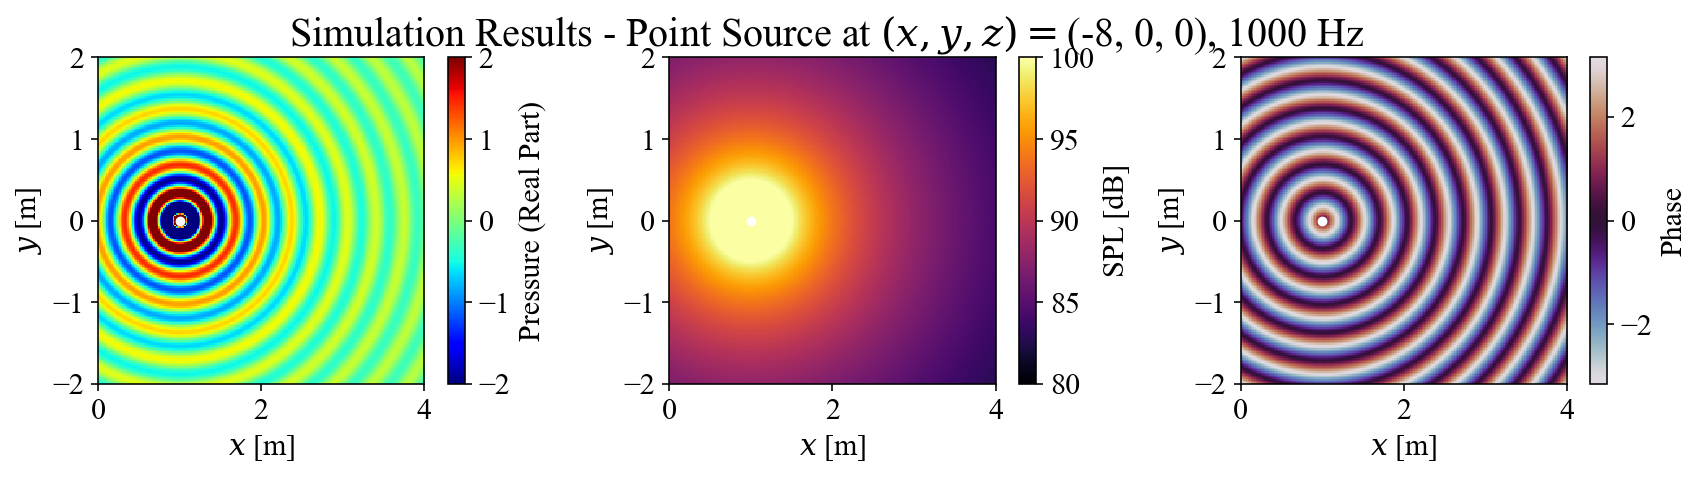

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(14.5, 3))
fig.suptitle(fr'Simulation Results - Point Source at $(x, y, z)=$(-8, 0, 0), {FREQS[0]} Hz', size=20)

im1 = axes[0].pcolorfast(X, Y, PRESSURE[0].real.reshape(X.size, Y.size), vmin=-2.0, vmax=2.0, cmap='jet')
axes[0].set_aspect('equal')
axes[0].set_xlabel(r'$x$ [m]')
axes[0].set_ylabel(r'$y$ [m]')
fig.colorbar(im1, ax=axes[0]).set_label('Pressure (Real Part)')

im2 = axes[1].pcolorfast(X, Y, SPL[0].reshape(X.size, Y.size), vmin=100, vmax=80, cmap='inferno')
axes[1].set_aspect('equal')
axes[1].set_xlabel(r'$x$ [m]')
axes[1].set_ylabel(r'$y$ [m]')
fig.colorbar(im2, ax=axes[1]).set_label('SPL [dB]')

im3 = axes[2].pcolorfast(X, Y, PHASE[0].reshape(X.size, Y.size), cmap='twilight')
axes[2].set_aspect('equal')
axes[2].set_xlabel(r'$x$ [m]')
axes[2].set_ylabel(r'$y$ [m]')
fig.colorbar(im3, ax=axes[2]).set_label('Phase')

for ax in axes:
    ax.scatter(POINT_SOURCE.get_arbit_param('x'),
               POINT_SOURCE.get_arbit_param('y'),
               s=15, c='white', marker="o", label='Microphones')

fig.subplots_adjust()